# Multi-Class Classification NN Sequential Model on Spirals dataset

In [37]:
# Import libraries
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [38]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [39]:
# Set random seed for reporductivity
RANDOM_SEED = 42

## 1. Prepare data

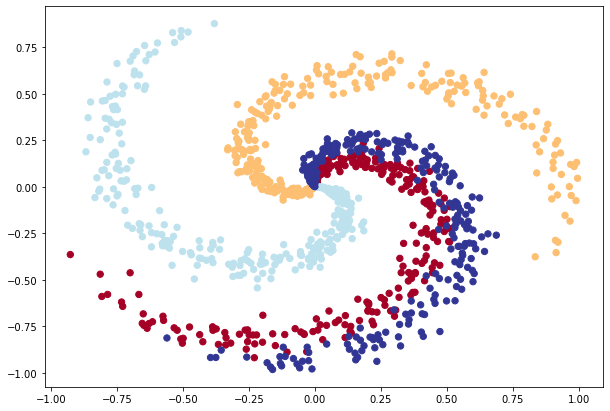

In [40]:
# Code for creating a spiral dataset from CS231n
np.random.seed(RANDOM_SEED)
N = 250 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [41]:
X[:10], y[:10]

(array([[ 0.00000000e+00,  0.00000000e+00],
        [-4.65395334e-05,  4.01579459e-03],
        [ 1.29287489e-03,  7.92739320e-03],
        [ 4.16295811e-03,  1.13061368e-02],
        [ 2.79927248e-04,  1.60618179e-02],
        [ 6.72442402e-04,  2.00690589e-02],
        [ 9.65425973e-03,  2.20778410e-02],
        [ 7.38832286e-03,  2.71242054e-02],
        [ 1.11204062e-03,  3.21092632e-02],
        [ 9.05049486e-03,  3.49931291e-02]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [42]:
# Convert data to pandas dataframe
df_spiral = pd.DataFrame({"X1":X[:, 0],
                          "X2":X[:, 1],
                          "label":y})
df_spiral.head()

,X1,X2,label
0,0.000000,0.000000,0
1,-0.000047,0.004016,0
2,0.001293,0.007927,0
3,0.004163,0.011306,0
4,0.000280,0.016062,0


In [43]:
# Check dataset's balance
df_spiral["label"].value_counts()

0    250
1    250
2    250
3    250
Name: label, dtype: int64

In [44]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long (integers)

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Create a model

In [45]:
hidden_units = 8

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Tanh(),
        nn.Linear(in_features=hidden_units, out_features=4)
    )

  def forward(self, x):
    return self.layer_stack(x)


# Instantiate model and send it to device
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model_0 = SpiralModel().to(device)
model_0

SpiralModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [46]:
# Setup loss function, optimizer and accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.1)


# Let's calculuate the accuracy for when we fit our model
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [47]:
model_0.state_dict()

OrderedDict([('layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, 

In [48]:
# Preview the model output
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_train.to(device)).squeeze()
    
y_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_probs, dim=1)

print("Label format")
print(y_train[:10])

print("\nModel output - logits")
print(y_logits[:10])

print("\nModel output - probabilities")
print(y_probs[:10])

print("\nModel output - classes")
print(y_preds[:10])

print("\nOutput match:")
print(y_train.shape == y_preds.shape)

Label format
tensor([0, 2, 2, 2, 3, 2, 0, 3, 1, 3])

Model output - logits
tensor([[ 0.1728, -0.3636,  0.1207,  0.0896],
        [ 0.1707, -0.3377,  0.1209,  0.0629],
        [ 0.2741, -0.3766,  0.2350,  0.2047],
        [ 0.1745, -0.3268,  0.1269,  0.0569],
        [ 0.1212, -0.3493,  0.0737,  0.0541],
        [ 0.2090, -0.3117,  0.1687,  0.0763],
        [ 0.2013, -0.3096,  0.1623,  0.0803],
        [ 0.1030, -0.3121,  0.0702,  0.0396],
        [ 0.0221, -0.3364, -0.0314, -0.0153],
        [ 0.1504, -0.3740,  0.0974,  0.0872]])

Model output - probabilities
tensor([[0.2895, 0.1693, 0.2748, 0.2664],
        [0.2898, 0.1743, 0.2757, 0.2602],
        [0.2927, 0.1527, 0.2815, 0.2731],
        [0.2900, 0.1757, 0.2765, 0.2578],
        [0.2846, 0.1778, 0.2714, 0.2662],
        [0.2915, 0.1732, 0.2800, 0.2553],
        [0.2900, 0.1740, 0.2789, 0.2570],
        [0.2804, 0.1851, 0.2713, 0.2632],
        [0.2770, 0.1936, 0.2626, 0.2668],
        [0.2874, 0.1701, 0.2726, 0.2698]])

Model output

## 3. Train model

In [49]:
# Put tensors to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Create train log lists
log_epochs = []
log_train_loss = []
log_train_acc = []
log_test_loss = []
log_test_acc = []

# Manual seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Training loop
epochs = 1000

for epoch in range(epochs):
    
    ### Training
    model_0.train()
    
    # Forward pass and outputs
    y_logits = model_0(X_train).squeeze()
    y_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_probs, dim=1)
    
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_preds, y_train)
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Gradient descent
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward Pass
        test_logits = model_0(X_test).squeeze()
    
    # Convert output to preds and labels
    test_preds = torch.softmax(test_logits, dim=1)
    test_labels = torch.argmax(test_preds, dim=1)
    
    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_labels, y_test)
    
    ### Collect log data
    log_epochs.append(epoch)
    log_train_loss.append(loss)
    log_train_acc.append(acc)
    log_test_loss.append(test_loss)
    log_test_acc.append(test_acc)
    
    ### Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Accuracy: {acc:2f}% | Test loss: {test_loss:.2f}, Test accuracy: {test_acc:2f}%")

Epoch: 0 | Loss: 1.40, Accuracy: 0.257500% | Test loss: 1.36, Test accuracy: 0.295000%
Epoch: 100 | Loss: 0.17, Accuracy: 0.931250% | Test loss: 0.17, Test accuracy: 0.950000%
Epoch: 200 | Loss: 0.15, Accuracy: 0.942500% | Test loss: 0.16, Test accuracy: 0.945000%
Epoch: 300 | Loss: 0.14, Accuracy: 0.941250% | Test loss: 0.17, Test accuracy: 0.950000%
Epoch: 400 | Loss: 0.13, Accuracy: 0.945000% | Test loss: 0.17, Test accuracy: 0.950000%
Epoch: 500 | Loss: 0.13, Accuracy: 0.947500% | Test loss: 0.19, Test accuracy: 0.965000%
Epoch: 600 | Loss: 0.12, Accuracy: 0.951250% | Test loss: 0.17, Test accuracy: 0.950000%
Epoch: 700 | Loss: 0.12, Accuracy: 0.952500% | Test loss: 0.21, Test accuracy: 0.950000%
Epoch: 800 | Loss: 0.12, Accuracy: 0.951250% | Test loss: 0.19, Test accuracy: 0.950000%
Epoch: 900 | Loss: 0.12, Accuracy: 0.952500% | Test loss: 0.21, Test accuracy: 0.950000%


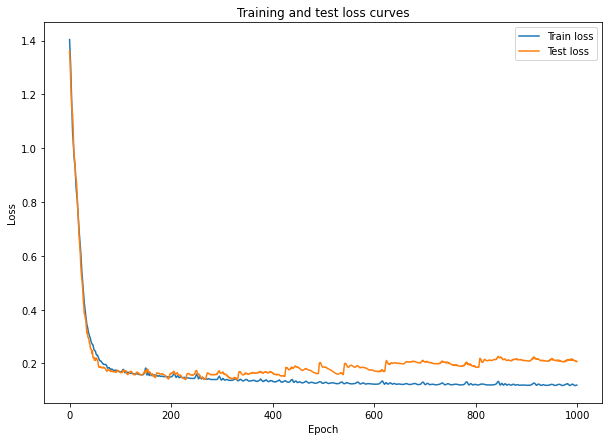

In [50]:
# Convert log lists to numpy arrays
log_epochs = torch.tensor(log_epochs).cpu().numpy()
log_train_loss = torch.tensor(log_train_loss).cpu().numpy()
log_train_acc = torch.tensor(log_train_acc).cpu().numpy()
log_test_loss = torch.tensor(log_test_loss).cpu().numpy()
log_test_acc = torch.tensor(log_test_acc).cpu().numpy()


# Plot the loss curves
plt.figure(figsize=(10, 7))
plt.plot(log_epochs, log_train_loss, label="Train loss")
plt.plot(log_epochs, log_test_loss, label="Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [51]:
# Create log file
training_logs = pd.DataFrame({"Epoch": log_epochs,
                              "Train loss": log_train_loss,
                              "Train accuracy": log_train_acc,
                              "Test loss": log_test_loss,
                              "Test accuracy": log_test_acc})

training_logs.head(), training_logs.tail()

(   Epoch  Train loss  Train accuracy  Test loss  Test accuracy
 0      0    1.403595         0.25750   1.360927          0.295
 1      1    1.355344         0.28625   1.324106          0.400
 2      2    1.314667         0.35750   1.263214          0.390
 3      3    1.247475         0.42625   1.206397          0.395
 4      4    1.177281         0.45750   1.160103          0.395,
      Epoch  Train loss  Train accuracy  Test loss  Test accuracy
 995    995    0.118023         0.95250   0.209854          0.950
 996    996    0.117987         0.95125   0.210115          0.945
 997    997    0.118409         0.95625   0.207798          0.950
 998    998    0.118979         0.95125   0.209015          0.955
 999    999    0.119463         0.95375   0.206438          0.950)

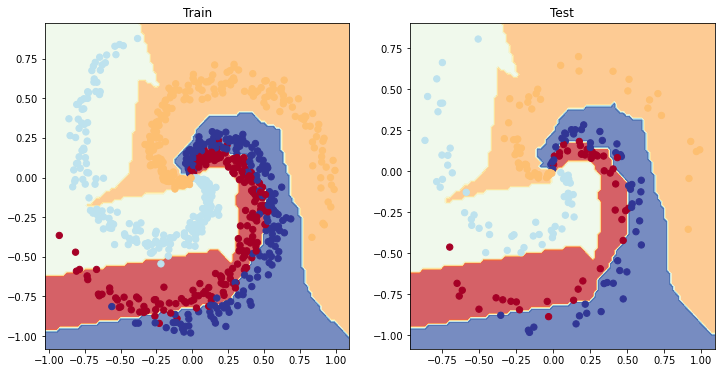

In [52]:
# Plot decision boundary

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 3. Evaluate model

In [53]:
# Get model's predictions
model_0.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

model_0.eval()
with torch.inference_mode():
    # Forward Pass
    test_logits = model_0(X_test).squeeze()
    
# Convert output to preds and labels
test_preds = torch.softmax(test_logits, dim=1)
test_labels = torch.argmax(test_preds, dim=1)

In [54]:
# Confusion matrix
from torchmetrics.classification import ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes=4)
confmat(test_labels, y_test)

tensor([[38,  0,  1,  5],
        [ 0, 52,  0,  0],
        [ 0,  1, 54,  0],
        [ 3,  0,  0, 46]])

In [55]:
# Precision
from torchmetrics.classification import MulticlassPrecision
precision_fn = MulticlassPrecision(num_classes=4)
precision_score = precision_fn(test_labels, y_test)
print(f"Precision: {precision_score}")

# Recall
from torchmetrics.classification import MulticlassRecall
recall_fn = MulticlassRecall(num_classes=4)
recall_score = recall_fn(test_labels, y_test).item()
print(f"Recall: {recall_score}")

# F1
from torchmetrics.classification import MulticlassF1Score
f1_fn = MulticlassF1Score(num_classes=4)
f1_score = f1_fn(test_labels, y_test)
print(f"F1: {f1_score}")

Precision: 0.9479351043701172
Recall: 0.9460575580596924
F1: 0.9466030597686768
